# Calculate a Transportation Distribution Charge

#### A Transportation Distribution Charge is a charge levied by the Distribution companies for the use of their lower pressure pipelines. The charge covers the cost of physically transporting the gas through the pipeline. The cost is variable in time and is determined by the Exit Zone (a regional code) and the (estimated) rolling consumption quantity of the meter.

In [1]:
import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [2]:
filename = 'data.xlsx'

In [3]:
#df1 = pd.read_excel(filename, sheet_name = 'Forecasted Consumption')

In [4]:
df_dummy = pd.ExcelFile(filename)
sheet1 = df_dummy.parse(0)
sheet2 = df_dummy.parse(1)
sheet3 = df_dummy.parse(2)

In [5]:
print(sheet1.dtypes)
print("------")
print(sheet2.dtypes)
print("------")
print(sheet3.dtypes)

Date        datetime64[ns]
Meter ID             int64
kWh                float64
dtype: object
------
Meter ID                  int64
Exit Zone                object
Annual Quantity (kWh)     int64
dtype: object
------
Date                     datetime64[ns]
Exit Zone                        object
Annual Quantity (Min)             int64
Annual Quantity (Max)           float64
Rate (p/kWh)                    float64
dtype: object


In [6]:
sheet1.info()
print()
print("---------------------")
print()
sheet2.info()
print()
print("---------------------")
print()
sheet3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 3 columns):
Date        2190 non-null datetime64[ns]
Meter ID    2190 non-null int64
kWh         2190 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 51.5 KB

---------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
Meter ID                 3 non-null int64
Exit Zone                3 non-null object
Annual Quantity (kWh)    3 non-null int64
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes

---------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 5 columns):
Date                     1026 non-null datetime64[ns]
Exit Zone                1026 non-null object
Annual Quantity (Min)    1026 non-null int64
Annual Quantity (Max)    684 non-null float64
Rate (p/kWh)             1026 non-null float64
dtypes: datetime64[ns](1), float64(2), int6

In [7]:
sheet3

Date Exit Zone  Annual Quantity (Min)  Annual Quantity (Max)  \
0    2020-04-01       EA1                      0                73200.0   
1    2020-04-01       EA2                      0                73200.0   
2    2020-04-01       EA3                      0                73200.0   
3    2020-04-01       EA4                      0                73200.0   
4    2020-04-01       EM1                      0                73200.0   
...         ...       ...                    ...                    ...   
1021 2024-04-01       WA1                 732000                    NaN   
1022 2024-04-01       WA2                 732000                    NaN   
1023 2024-04-01       WM1                 732000                    NaN   
1024 2024-04-01       WM2                 732000                    NaN   
1025 2024-04-01       WM3                 732000                    NaN   

      Rate (p/kWh)  
0         0.028700  
1         0.028700  
2         0.028700  
3         0.028700  
4         0.028700  
...            ...  
1021      0.384755  
1022      0.384755  
1023      0.445482  
1024      0.445482  
1025      0.445482  

[1026 rows x 5 columns]

In [8]:
A_date = sheet3['Date'][sheet3['Exit Zone']=='EA1']
A_date

0     2020-04-01
38    2020-04-01
76    2020-04-01
114   2020-10-01
152   2020-10-01
190   2020-10-01
228   2021-04-01
266   2021-04-01
304   2021-04-01
342   2021-10-01
380   2021-10-01
418   2021-10-01
456   2022-04-01
494   2022-04-01
532   2022-04-01
570   2022-10-01
608   2022-10-01
646   2022-10-01
684   2023-04-01
722   2023-04-01
760   2023-04-01
798   2023-10-01
836   2023-10-01
874   2023-10-01
912   2024-04-01
950   2024-04-01
988   2024-04-01
Name: Date, dtype: datetime64[ns]

/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


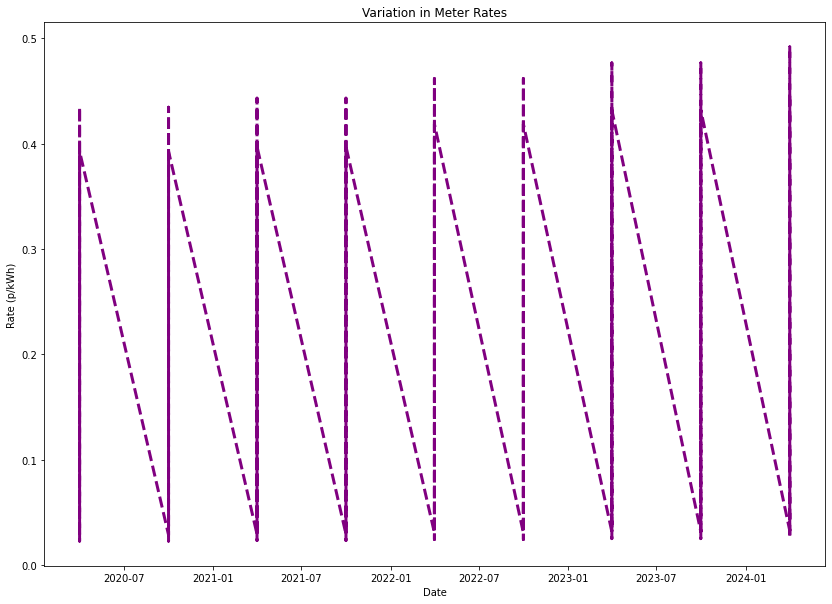

In [9]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(14, 10))

# Add x-axis and y-axis
ax.plot(sheet3['Date'], sheet3['Rate (p/kWh)'], color='purple', ls='--', lw=3)

# Set title and labels for axes
ax.set(xlabel="Date", ylabel="Rate (p/kWh)", title="Variation in Meter Rates")
size=25
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': 15,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)


plt.show()

In [10]:
for i in range (len(sheet2['Meter ID'])):
    print (sheet1[sheet1['Meter ID'] == sheet2['Meter ID'][i]])

           Date    Meter ID        kWh
0    2020-10-01  1000000603  28.782474
3    2020-10-02  1000000603  26.690797
6    2020-10-03  1000000603  21.511312
9    2020-10-04  1000000603  22.801972
12   2020-10-05  1000000603  30.805517
...         ...         ...        ...
2175 2022-09-26  1000000603  18.553369
2178 2022-09-27  1000000603  18.801933
2181 2022-09-28  1000000603  19.015036
2184 2022-09-29  1000000603  19.263599
2187 2022-09-30  1000000603  17.927143

[730 rows x 3 columns]
           Date  Meter ID         kWh
1    2020-10-01  10588707  126.367711
4    2020-10-02  10588707  118.322449
7    2020-10-03  10588707   94.272125
10   2020-10-04  10588707   97.641038
13   2020-10-05  10588707  138.761245
...         ...       ...         ...
2176 2022-09-26  10588707   73.614794
2179 2022-09-27  10588707   75.116336
2182 2022-09-28  10588707   76.430689
2185 2022-09-29  10588707   77.744203
2188 2022-09-30  10588707   73.335098

[730 rows x 3 columns]
           Date  Meter ID   

In [11]:
newSheet3 = sheet3[(sheet3['Date'] >= '1-10-2020') & (sheet3['Date'] <= '30-09-2022')]

print(sheet3.info())
print()
print(newSheet3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 5 columns):
Date                     1026 non-null datetime64[ns]
Exit Zone                1026 non-null object
Annual Quantity (Min)    1026 non-null int64
Annual Quantity (Max)    684 non-null float64
Rate (p/kWh)             1026 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 40.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 0 to 569
Data columns (total 5 columns):
Date                     570 non-null datetime64[ns]
Exit Zone                570 non-null object
Annual Quantity (Min)    570 non-null int64
Annual Quantity (Max)    380 non-null float64
Rate (p/kWh)             570 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 26.7+ KB
None


In [12]:
## find the metreID and exitZone mapping from sheet2
 
sheet2Reduced = sheet2.drop('Annual Quantity (kWh)', 1)
exitZones = sheet2Reduced['Exit Zone'].tolist()

In [13]:
ezone = sheet3['Exit Zone']

In [14]:
zoneToMeter = {}

for zone in exitZones:
    tempDf = sheet2Reduced[sheet2Reduced['Exit Zone'] == zone]
    mID = tempDf.iloc[0]['Meter ID']
    zoneToMeter[zone] = mID

for key in zoneToMeter.keys():
    print(key, zoneToMeter[key])

SC1 1000000603
EM2 10588707
NW1 10626610


In [15]:
sheet3 = newSheet3

In [16]:
newSheet3 = sheet3.loc[sheet3['Exit Zone'].isin(exitZones)]
newSheet3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 5 to 555
Data columns (total 5 columns):
Date                     45 non-null datetime64[ns]
Exit Zone                45 non-null object
Annual Quantity (Min)    45 non-null int64
Annual Quantity (Max)    30 non-null float64
Rate (p/kWh)             45 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 2.1+ KB


In [17]:
print(random.choice(ezone))

LS


In [18]:
#print(random.randint(0,1000))
print(random.uniform(0,100000))
print(random.random())

7291.894330622684
0.7665294977597312


In [19]:
newSheet3 = newSheet3[newSheet3['Date'] != '2020-04-01']

In [20]:
newSheet3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 119 to 555
Data columns (total 5 columns):
Date                     36 non-null datetime64[ns]
Exit Zone                36 non-null object
Annual Quantity (Min)    36 non-null int64
Annual Quantity (Max)    24 non-null float64
Rate (p/kWh)             36 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.7+ KB


In [21]:
sheet3 = newSheet3

In [22]:
def relevant_dates(sheet3):
    rateDates = sheet3['Date'].unique()
    sortedRateDates = sorted(rateDates)

    return sortedRateDates


In [23]:
sortedRateDates = relevant_dates(sheet3)
sortedRateDates

[numpy.datetime64('2020-10-01T00:00:00.000000000'),
 numpy.datetime64('2021-04-01T00:00:00.000000000'),
 numpy.datetime64('2021-10-01T00:00:00.000000000'),
 numpy.datetime64('2022-04-01T00:00:00.000000000')]

In [24]:
metreIDs = sheet2['Meter ID'].unique()
print(metreIDs, type(metreIDs))

[1000000603   10588707   10626610] <class 'numpy.ndarray'>


In [25]:
def Consumption (metreIDs, sheet1, sortedRateDates):
    consumptionData = []

    for metreID in metreIDs:
        sheet1Reduced = sheet1[sheet1['Meter ID'] == metreID]
        d = {}
        for idx, date in enumerate(sortedRateDates):
            if(idx != len(sortedRateDates)-1):
                nxtDate = sortedRateDates[idx+1]
                tempDf = sheet1Reduced[sheet1Reduced['Date'] >= date]
                tempDf = tempDf[tempDf['Date'] < nxtDate]
                val = tempDf['kWh'].sum()
                d[date] = [metreID , val]
            else:
                tempDf = sheet1Reduced[sheet1Reduced['Date'] >= date]
                val = tempDf['kWh'].sum()
                d[date] = [metreID , val]
        consumptionData.append(d)
        
    return (consumptionData)

In [26]:
CD = Consumption(metreIDs, sheet1, sortedRateDates)

In [27]:
for data in CD:
    for key in data.keys():
        print(key , data[key])
    print('------------------------------')

2020-10-01T00:00:00.000000000 [1000000603, 8908.61620600899]
2021-04-01T00:00:00.000000000 [1000000603, 3428.383793990991]
2021-10-01T00:00:00.000000000 [1000000603, 8790.85792188759]
2022-04-01T00:00:00.000000000 [1000000603, 3546.1420782475916]
------------------------------
2020-10-01T00:00:00.000000000 [10588707, 46488.11297780813]
2021-04-01T00:00:00.000000000 [10588707, 14736.887021688537]
2021-10-01T00:00:00.000000000 [10588707, 45783.81639460087]
2022-04-01T00:00:00.000000000 [10588707, 15441.183605399012]
------------------------------
2020-10-01T00:00:00.000000000 [10626610, 105024.35742833954]
2021-04-01T00:00:00.000000000 [10626610, 46754.64257166028]
2021-10-01T00:00:00.000000000 [10626610, 103681.9437768501]
2022-04-01T00:00:00.000000000 [10626610, 48097.056224813074]
------------------------------


In [28]:
def Rate(sheet3, exitZones, sortedRateDates):
    rateData = []

    for zone in exitZones:
        rateDataDict = {}
        for date in sortedRateDates:
            tempDf = sheet3[sheet3['Date'] == date]
            tempDf = tempDf[tempDf['Exit Zone'] == zone]
            rates = tempDf['Rate (p/kWh)'].tolist()
            rateDataDict[date] = [zone , rates]
        rateData.append(rateDataDict)
    return (rateData)

In [29]:
for data in Rate(sheet3, exitZones, sortedRateDates):
    for key in data.keys():
        data[key][0] = zoneToMeter[data[key][0]]
        print(key, data[key])
    print("--------------------------")

2020-10-01T00:00:00.000000000 [1000000603, [0.0333, 0.0297, 0.2431]]
2021-04-01T00:00:00.000000000 [1000000603, [0.033312536189378, 0.0297111809256614, 0.243191517947081]]
2021-10-01T00:00:00.000000000 [1000000603, [0.033312536189378, 0.0297111809256614, 0.243191517947081]]
2022-04-01T00:00:00.000000000 [1000000603, [0.03470596778416, 0.0309539712669535, 0.253363987036916]]
--------------------------
2020-10-01T00:00:00.000000000 [10588707, [0.0287, 0.0228, 0.182]]
2021-04-01T00:00:00.000000000 [10588707, [0.0294050827624451, 0.0233601354349738, 0.186471256542335]]
2021-10-01T00:00:00.000000000 [10588707, [0.0294050827624451, 0.0233601354349738, 0.186471256542335]]
2022-04-01T00:00:00.000000000 [10588707, [0.0306609794113917, 0.0243578512397119, 0.194435479194191]]
--------------------------
2020-10-01T00:00:00.000000000 [10626610, [0.0339, 0.0285, 0.2474]]
2021-04-01T00:00:00.000000000 [10626610, [0.0345836043372242, 0.0290747116109407, 0.252388900089359]]
2021-10-01T00:00:00.00000000

# Task 1

In [30]:
def TDC(metreIDs, sheet1, sheet3, exitZones, sortedRateDates):
    '''
    metreIDs: list with the metreIDs of the customer of whom we wish to find the cost
    sheet1: dataframe which provides data related to forecasted consumption
    sheet3: dataframe which gives the rate information in different reading date at different exitZone
    exitZones: list of exitZones 
    sortedRateDates: dates on which reading date and rate mapping is provided
    '''
    
    costDict = {}
    consumeDict = {}

    rateData = Rate(sheet3, exitZones, sortedRateDates)

    for idx, data in enumerate(Consumption(metreIDs, sheet1, sortedRateDates)):
        for date in sortedRateDates:
            data[date][0] == rateData[idx][date][0]

            consumed = data[date][1]
            charges = None
            if(consumed >= 0 and consumed < 73200):
                charges = rateData[idx][date][1][0]
            elif(consumed >= 73200 and consumed < 732000):
                charges = rateData[idx][date][1][1]
            elif(consumed >= 732000):
                charges = rateData[idx][date][1][2] 

            charges = charges * consumed

            if(str(data[date][0]) in costDict.keys()):
                costDict[str(data[date][0])] += float("{:.2f}".format((0.1 * charges)))
                consumeDict[str(data[date][0])] += float("{:.2f}".format((consumed)))
            else:
                costDict[str(data[date][0])] = float("{:.2f}".format((0.1 * charges)))
                consumeDict[str(data[date][0])] = float("{:.2f}".format((consumed)))
                
    costDataFrame = pd.DataFrame(costDict.items(), columns=['Meter ID', 'Total Cost (£)'])
    consumptionDataFrame = pd.DataFrame(consumeDict.items(), columns=['Meter ID', 'Total Estimated Consumption(kWh)'])
    mergedDf = pd.merge(consumptionDataFrame, costDataFrame, on="Meter ID")

    return (mergedDf)


In [31]:
TDC(metreIDs, sheet1, sheet3, exitZones, sortedRateDates)

Meter ID  Total Estimated Consumption(kWh)  Total Cost (£)
0  1000000603                           24674.0           82.68
1    10588707                          122450.0          358.72
2    10626610                          303558.0          935.71

In [32]:
TDC_ = TDC(metreIDs, sheet1, sheet3, exitZones, sortedRateDates)

In [36]:
TDC_


Meter ID  Total Estimated Consumption(kWh)  Total Cost (£)
0  1000000603                           24674.0           82.68
1    10588707                          122450.0          358.72
2    10626610                          303558.0          935.71

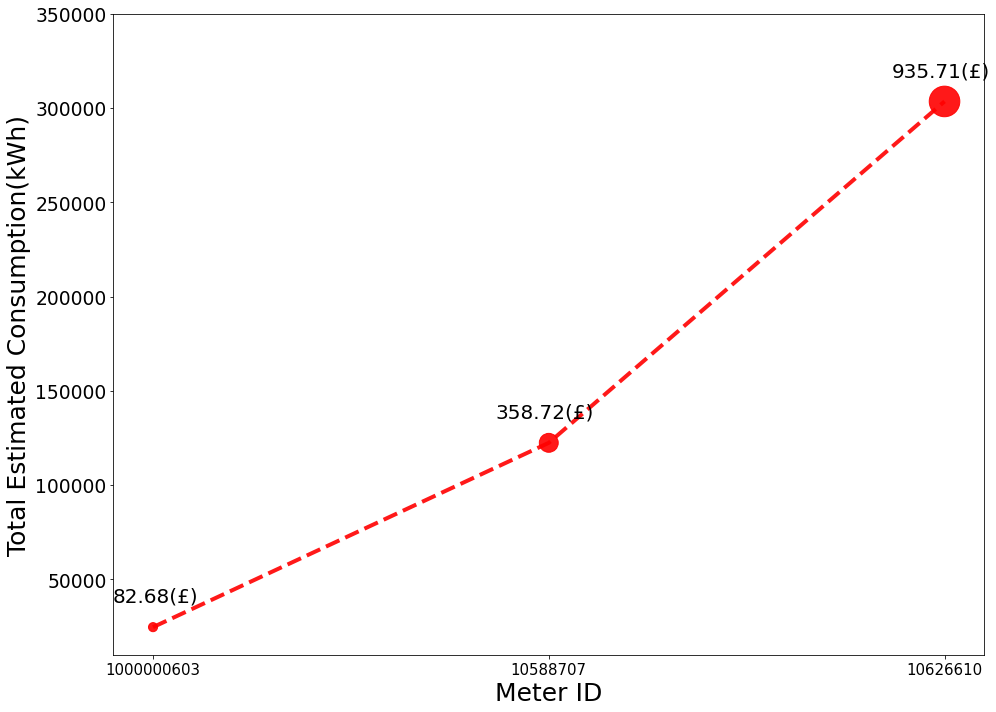

In [39]:
fig, ax = plt.subplots(figsize=(14, 10))

plt.scatter(TDC_['Meter ID'],TDC_['Total Estimated Consumption(kWh)'], s=TDC_['Total Cost (£)'], c='r', alpha=0.9)
plt.plot(TDC_['Meter ID'],TDC_['Total Estimated Consumption(kWh)'], c='r', ls='--', lw=4, alpha=0.9)
plt.xlabel("Meter ID")
plt.ylabel("Total Estimated Consumption(kWh)")

i = 0
# zip joins x and y coordinates in pairs
for x,y in zip(TDC_['Meter ID'].tolist(),TDC_['Total Estimated Consumption(kWh)'].tolist()):
    
    label = TDC_['Total Cost (£)'].tolist()
    

    plt.annotate(str(label[i])+"(£)", # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(45,25), # distance from text to points (x,y)
                 ha='right',fontsize=20) # horizontal alignment can be left, right or center
    i +=1
    
plt.ylim(10000, 350000)
plt.tight_layout()

plt.show()

# Task 2

In [40]:
def Random_meter(N=random.randint(0,100)):
    ez = []
    aq = []
    mid = []
    for i in range(N):
        EZ = random.choice(ezone)
        AQ = random.uniform(0,100000)
        ez.append(EZ)
        aq.append(AQ)
        mid.append(random.randint(0,10000))
        
    D_tuples = list(zip(mid, ez, aq))
    
    DF = pd.DataFrame(D_tuples, columns = ['Meter ID', 'Exit Zone', 'Annual Quantity (kWh)'])
    
    return (DF)

In [41]:
Random_meter()

Empty DataFrame
Columns: [Meter ID, Exit Zone, Annual Quantity (kWh)]
Index: []

In [42]:
my_date = '2020-10-31'

In [43]:
my_date = datetime.strptime(my_date, "%Y-%m-%d")
print (my_date)

2020-10-31 00:00:00


In [44]:
print ('Month', my_date.month)
print ('Year', my_date.year)

Month 10
Year 2020


In [45]:
t = np.arange(datetime(1985,7,1), datetime(2015,7,1), timedelta(days=1)).astype(datetime)


In [46]:
A= pd.date_range(start="2018-09-09",end="2020-02-02").to_pydatetime().tolist()


In [47]:
len(A)

512

In [48]:
sheet1['Date'] = pd.to_datetime(sheet1['Date'])
data = sheet1.set_index('Date')

In [49]:
data

Meter ID         kWh
Date                              
2020-10-01  1000000603   28.782474
2020-10-01    10588707  126.367711
2020-10-01    10626610  326.240595
2020-10-02  1000000603   26.690797
2020-10-02    10588707  118.322449
...                ...         ...
2022-09-29    10588707   77.744203
2022-09-29    10626610  270.357196
2022-09-30  1000000603   17.927143
2022-09-30    10588707   73.335098
2022-09-30    10626610  263.375674

[2190 rows x 2 columns]

In [50]:
data[['kWh']]

kWh
Date                  
2020-10-01   28.782474
2020-10-01  126.367711
2020-10-01  326.240595
2020-10-02   26.690797
2020-10-02  118.322449
...                ...
2022-09-29   77.744203
2022-09-29  270.357196
2022-09-30   17.927143
2022-09-30   73.335098
2022-09-30  263.375674

[2190 rows x 1 columns]

In [51]:
data_consumption = data[['kWh']]
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'kWh'].shift()
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
data_consumption = data_consumption.dropna()

In [52]:
data_consumption

kWh   Yesterday  Yesterday_Diff
Date                                              
2020-10-01  326.240595  126.367711       97.585236
2020-10-02   26.690797  326.240595      199.872884
2020-10-02  118.322449   26.690797     -299.549798
2020-10-02  316.860290  118.322449       91.631652
2020-10-03   21.511312  316.860290      198.537841
...                ...         ...             ...
2022-09-29   77.744203   19.263599     -248.005488
2022-09-29  270.357196   77.744203       58.480604
2022-09-30   17.927143  270.357196      192.612993
2022-09-30   73.335098   17.927143     -252.430053
2022-09-30  263.375674   73.335098       55.407955

[2188 rows x 3 columns]

In [53]:
X_train = data_consumption[:'2020'].drop(['kWh'], axis = 1)
y_train = data_consumption.loc[:'2020', 'kWh']
X_test = data_consumption['2022'].drop(['kWh'], axis = 1)
y_test = data_consumption.loc['2022', 'kWh']

In [54]:
X_test

Yesterday  Yesterday_Diff
Date                                  
2022-01-01  614.239586      324.646178
2022-01-01   46.929989     -567.309597
2022-01-01  239.867550      192.937561
2022-01-02  580.948407      341.080857
2022-01-02   47.061218     -533.887190
...                ...             ...
2022-09-29   19.263599     -248.005488
2022-09-29   77.744203       58.480604
2022-09-30  270.357196      192.612993
2022-09-30   17.927143     -252.430053
2022-09-30   73.335098       55.407955

[819 rows x 2 columns]

LR: 0.345770 (0.187792)
LASSO: 0.345807 (0.187780)
RF: 0.636988 (0.401315)


/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


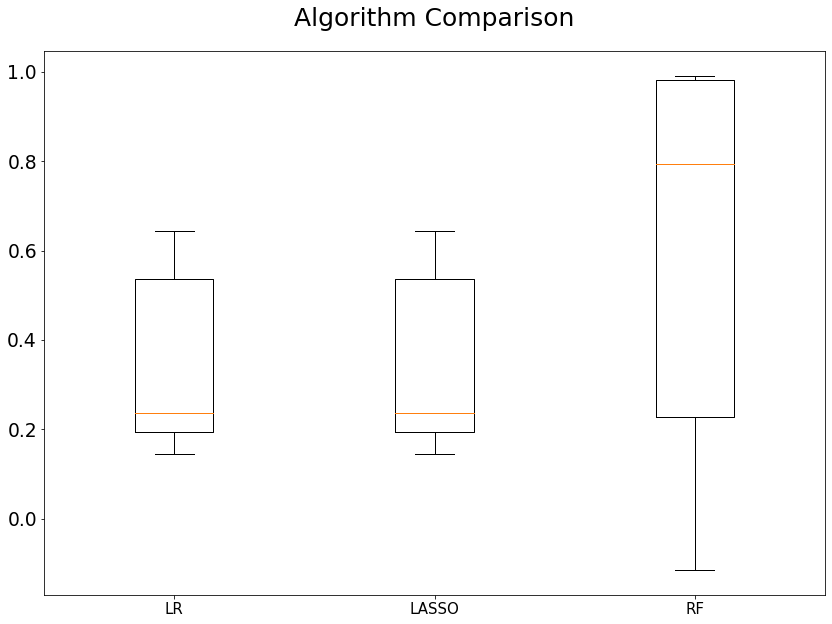

In [55]:
# Testing some time series Algorithms
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('LASSO', linear_model.Lasso()))
models.append(('RF', RandomForestRegressor()))


# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=12)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
fig, ax = plt.subplots(figsize=(14, 10))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [56]:
y_true = y_test.values
RF = RandomForestRegressor()
pmodel = RF.fit(X_train, y_train)
y_pred = pmodel.predict(X_test)

/Users/sampathmukherjee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
len(y_pred)

819

In [58]:
K=[random.uniform(0,500) for i in range(10)]
print (K)

[215.69949849729224, 342.23709778145184, 434.7903979085791, 497.97858095394173, 368.3292590870729, 87.28070705960562, 319.30450851107196, 287.0701567703032, 332.5106891674039, 36.84282423842866]


In [59]:
A= pd.date_range(start="2018-09-09",end="2020-02-02").to_pydatetime().tolist()
    
kWh = [random.uniform(0,500) for i in range(len(A))]
    
mock_data = list(zip(A, kWh))
    
    
data_mock = pd.DataFrame(mock_data, columns = ['Date', 'kWh'])
    

# Task 3

In [60]:
def mock_consumption(mlist=[8900], start = '2020-10-31', end = '2022-10-31'):
    
    if start>end:
        return(print ('CAUTION: Your start date should not be in future than end date'))
        
    
    mock_meter_consumption_list = np.array(len(mlist))
    frames = []
    
    for k in range (len(mlist)):
        
        #Range of the date
        A = pd.date_range(start = start, end = end).to_pydatetime().tolist()
        
        #Random kWh charges of the same length as dates
        kWh = [random.uniform(0,500) for i in range(len(A))]
    
        mock_data = list(zip(A, kWh))
        
        #Our raw_test_data_set for prediction
        data_mock = pd.DataFrame(mock_data, columns = ['Date', 'kWh'])
    
        # creating new dataframe from consumption column
        data_mock_consumption = data_mock[['kWh']]

        # inserting new column with yesterday's consumption values
        data_mock_consumption.loc[:,'Yesterday'] = data_mock_consumption.loc[:,'kWh'].shift()

        # inserting another column with difference between yesterday and day before yesterday's consumption values.
        data_mock_consumption.loc[:,'Yesterday_Diff'] = data_mock_consumption.loc[:,'Yesterday'].diff()

        # dropping NAs and kWh
        data_mock_consumption = data_mock_consumption.dropna()
        data_mock_consumption = data_mock_consumption.drop(['kWh'], axis = 1)
    
        data_mock_pred_consumption = pmodel.predict(data_mock_consumption)
    
        meter_ID = [mlist[k] for i in range(len(A))]
        
        meter_data = list(zip(A, meter_ID, data_mock_pred_consumption))
    
        mock_meter_consumption_list = pd.DataFrame( meter_data, columns = ['Date', 'Meter ID', 'kWh'])
        
        frames.append(mock_meter_consumption_list)    
    
    mock_meter_consumption = pd.concat(frames)
    
    return (mock_meter_consumption)
            
    

In [61]:
mock_consumption(mlist =[10626610, 10588707, 1000000603])

Date    Meter ID         kWh
0   2020-10-31    10626610   43.181082
1   2020-11-01    10626610  288.166064
2   2020-11-02    10626610   34.563815
3   2020-11-03    10626610   36.862346
4   2020-11-04    10626610  386.407653
..         ...         ...         ...
724 2022-10-25  1000000603  291.362431
725 2022-10-26  1000000603  281.082732
726 2022-10-27  1000000603   34.451490
727 2022-10-28  1000000603   32.034487
728 2022-10-29  1000000603  304.812578

[2187 rows x 3 columns]

In [62]:
mock_consumption(start = '2023-01-01') # Test for Date

CAUTION: Your start date should not be in future than end date


# Task 4

## Assumptions:
 ## 1. meter is a list
 ## 2. Consumption table 

In [63]:
def Random_meter_datagen_benchmark(metreIDs, N=random.randint(0,100)):
    ez = []
    aq = []
    mid = []
    idx = 0
    for i in range(N):
        EZ = random.choice(ezone)
        AQ = random.uniform(0,100000)
        ez.append(EZ)
        aq.append(AQ)
        mid.append(metreIDs[idx])
        idx += 1
        idx = idx % 3
        
    D_tuples = list(zip(mid, ez, aq))
    
    DF = pd.DataFrame(D_tuples, columns = ['Meter ID', 'Exit Zone', 'Annual Quantity (kWh)'])
    
    return (DF)

In [64]:
mlist = Random_meter_datagen_benchmark(metreIDs)['Meter ID']
mlist

0     1000000603
1       10588707
2       10626610
3     1000000603
4       10588707
         ...    
86      10626610
87    1000000603
88      10588707
89      10626610
90    1000000603
Name: Meter ID, Length: 91, dtype: int64

In [65]:
benchmark_data = mock_consumption(metreIDs, start = '2020-10-31', end = '2022-09-30')

In [66]:
benchmark_data['Meter ID'].value_counts()

10588707      698
10626610      698
1000000603    698
Name: Meter ID, dtype: int64

In [67]:
benchmark_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 697
Data columns (total 3 columns):
Date        2094 non-null datetime64[ns]
Meter ID    2094 non-null int64
kWh         2094 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 65.4 KB


In [68]:
benchmark_data

Date    Meter ID         kWh
0   2020-10-31  1000000603  229.207300
1   2020-11-01  1000000603  629.911675
2   2020-11-02  1000000603   32.524363
3   2020-11-03  1000000603  351.265025
4   2020-11-04  1000000603   33.650959
..         ...         ...         ...
693 2022-09-24    10626610  119.090625
694 2022-09-25    10626610  366.510331
695 2022-09-26    10626610  448.023100
696 2022-09-27    10626610   35.749669
697 2022-09-28    10626610   36.733710

[2094 rows x 3 columns]

In [69]:
sheet3 = df_dummy.parse(2)
newSheet3 = sheet3[(sheet3['Date'] >= '2020-10-31') & (sheet3['Date'] <= '2022-09-30')]

In [70]:
newSheet3 = newSheet3.loc[sheet3['Exit Zone'].isin(exitZones)]


In [71]:
newSheet3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 233 to 555
Data columns (total 5 columns):
Date                     27 non-null datetime64[ns]
Exit Zone                27 non-null object
Annual Quantity (Min)    27 non-null int64
Annual Quantity (Max)    18 non-null float64
Rate (p/kWh)             27 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.3+ KB


In [72]:
sortedRateDates = relevant_dates(newSheet3)
sortedRateDates

[numpy.datetime64('2021-04-01T00:00:00.000000000'),
 numpy.datetime64('2021-10-01T00:00:00.000000000'),
 numpy.datetime64('2022-04-01T00:00:00.000000000')]

In [73]:
TDC(metreIDs, benchmark_data, newSheet3, exitZones, sortedRateDates)

Meter ID  Total Estimated Consumption(kWh)  Total Cost (£)
0  1000000603                         120082.22          405.58
1    10588707                         113812.39          339.19
2    10626610                         109387.19          383.51

## Complexity analysis of the approach

> Task : Compute and return a dataframe describing Transportation cost

Let 

* $z$ denote number of unique zones
* $c$ denote number of rows in the forecasted consumption table
* $r$ denote number of unique reading dates

then time required is -----


For calculating 
* sortedRateDates : $O(r * logr)$ 

The functions
* Consumption() takes $O(z (c + rc))$ which is equivalent to $O(zrc)$

* Rate() takes $O(zr)$
* TDC() takes $O(zr + zr^2c)$  i.e. $O(zr^2c)$


## Task 5

The dominant term in my approach is the $r^2$ in the $O(zr^2c)$. That comes up as in this approach I take, $O(zr^2c)$ as $O(zrc) * O(r)$ where the $O(r)$ comes from the iteration over `sortedRateDates`. Now, in the output of `Consumption()` we already have the date related information. 

To improve the complexity, we should try and exlpore the means on how we can use that information.

